# Basic tutorial on how to use the quantum simulators

### This tutorial shows the basic idea of how to use the quantum assisted package to carry out Quantum Assisted Simulator (QAS), Truncated Taylor Quantum Simulator (TTQS) and the Classical Quantum Fast-Forwarding (CQFF)

Quantum Assisted Simulator: https://arxiv.org/abs/2011.06911, https://arxiv.org/abs/2011.14737, https://arxiv.org/abs/2101.07677

Truncated Taylor Quantum Simulator: https://arxiv.org/abs/2103.05500

Classical Quantum Fast-Forwarding: https://arxiv.org/abs/2104.01931

First, we describe how to use the quantum simulators without Qiskit, then we describe how we can use Qiskit to do the quantum simulation directly on the IBMQ computer.

### Import Packages

In [1]:
import numpy as np 
import ansatz_class_package as acp 
import pauli_class_package as pcp 
import hamiltonian_class_package as hcp 
import matrix_class_package as mcp 
import post_processing as pp
import plotting_package as plotp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

C:\Users\Kian Hwee\AppData\Local\Programs\Python\Python38\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


### Set parameters for the evaluation

In [2]:
uptowhatK = 4
num_qubits = 3
endtime = 8
num_steps = 1001

### Create the initial state (starting quantum state that will be used in QAS, TTQS and CQFF). Also define Hamiltonian here.

This initial state is basically $|\psi>$ in Definition 1 in https://arxiv.org/abs/2011.06911

In [3]:
#create initial state
random_generator = np.random.default_rng(123)
initial_state = acp.Initialstate(num_qubits, "efficient_SU2",random_generator, 5)
#define Hamiltonian
hamiltonian = hcp.transverse_ising_model_1d(num_qubits)
# hamiltonian = hcp.heisenberg_xyz_model(num_qubits)

#We can define arbitrary Hamiltonians
#EXAMPLE: If we have a 4 qubit system and I want to implement the hamiltonian H = 0.6*(XXII) + 0.4*(XZIY), the hamiltonian will be generated with this:   
#hcp.generate_arbitrary_hamiltonian(4,[0.6,0.4],["1100","1302"])

### Define the variables needed for computation on the quantum computer

In [4]:
import Qiskit_helperfunctions as qhf #IBMQ account is loaded here in this import
hub, group, project = "ibm-q-nus", "default", "reservations"


#IMBQ account is loaded in the importing of Qiskit_helperfunctions for now, so this part is commented out (KH, 5 may 2021)
#load IBMQ account. This step is needed if you want to run on the actual quantum computer
# This will throw an erorr if IMBQ account is not saved, consult qiskit docs for help
# IBMQ.load_account() 

#Other parameters for running on the quantum computer. Choose 1 to uncomment.
# sim = "noiseless_qasm"
# num_shots = 30000 #max is 1000000

sim = "noisy_qasm"
quantum_com = "ibmq_rome" #which quantum computer to take the noise profile from
num_shots = 8192 #max is 8192

# sim = "real"
# quantum_com = "ibmq_rome" #which quantum computer to actually run on
# num_shots = 8192 #max is 8192

quantum_computer_choice_results = qhf.choose_quantum_computer(hub, group, project, quantum_com)

#Example on how to create artificial noise model
#couplingmap = [[0,1],[1,2],[2,3],[3,4]]
#quantum_computer_choice_results = qhf.create_quantum_computer_simulation(couplingmap,depolarizingnoise=True,depolarizingnoiseparameter=0.03,bitfliperror=True,bitfliperrorparameter=0.03,measerror=True,measerrorparameter=0.03)

mitigate_meas_error = True 
meas_filter = qhf.measurement_error_mitigator(num_qubits, sim, quantum_computer_choice_results, shots = num_shots)

# mitigate_meas_error = False
# meas_filter = None

#expectation calculator here is an object that has a method that takes in a paulistring object P, and returns a <psi|P|psi>.
#This expectation calculator also stores previously calculated expectation values, so one doesn't need to compute the same expectation value twice.
expectation_calculator = qhf.expectation_calculator(initial_state, sim, quantum_computer_choice_results, meas_error_mitigate = mitigate_meas_error, meas_filter = meas_filter)

Calibrating POVM Matrix
Provider backend:  qasm_simulator


### How to run TTQS

This following segment shows how the code is meant to work.

1. Create initial Ansatz for K = 0
2. We need to iterate up to whatever K we want to go up to
3. At the start of each iteration, we use the Ansatz for the previous round to generate the new Ansatz. Typically done by the method described in QAS, by generating the new moments and adding them to the existing Ansatz (cumulative K-moment states)
4. Use the Ansatz to generate the E and D matrices, and set the initial alphas (the actual starting state we wish to perform time evolution on)
5. Specify parameters for the TTQS instance and evaluate
6. Update the Ansatz with the new alphas (basically the results of the evaluation)

In [5]:
#Run TTQS

#Some extra parameters for TTQS
optimizer = 'eigh' #or 'qcqp'
inv_cond = 10**(-6) #remove eigenvalues smaller than this

#create Initial Ansatz for K = 0
ansatz = acp.initial_ansatz(num_qubits)
#finalresults
finalresults = []
finalresults.append(ansatz)

for k in range(1,uptowhatK+1):
    print('Currently at K = ' + str(k))
    #Generate Ansatz for this round
    ansatz = acp.gen_next_ansatz(ansatz, hamiltonian, num_qubits) #By default, there is no processing when generating next Ansatz
    
    #Set initial alphas for Ansatz
    #Only 'start_with_initial_state' has been implemented thus far. 
    #This basically sets the state we want to evolve as the random, initial state we are using to generate the E and D matrices, for convenience
    acp.set_initial_alphas(num_qubits,ansatz,'start_with_initial_state') #for example alphas = (1, 0, 0, ...0 )
    E_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "E")
    D_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "D")
    
    #Here, we can specify how to evaluate the matrices. We can either evaluate the matrices by matrix multiplication,
    # or by using the quantum computer specified above

    # E_mat_evaluated =  E_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)
    # D_mat_evaluated = D_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)

    E_mat_evaluated =  E_mat_uneval.evaluate_matrix_with_qiskit_circuits(expectation_calculator)
    D_mat_evaluated = D_mat_uneval.evaluate_matrix_with_qiskit_circuits(expectation_calculator)
    
    #Get starting alphas
    startingstrings,startingalphas = ansatz.get_alphas()
    
    #Initialize TTQS instance and specify parameters
    TTQS_instance = pp.TTQS(num_qubits,D_mat_evaluated,E_mat_evaluated,startingalphas)
    TTQS_instance.numberstep(num_steps)
    TTQS_instance.define_endtime(endtime)
    TTQS_instance.define_optimizer(optimizer)
    TTQS_instance.define_invcond(inv_cond)
    
    #Run TTQS instance
    TTQS_instance.evaluate()

    #Get results
    result = TTQS_instance.get_results()

    #Update ansatz with the new alphas
    ansatz.update_alphas(result)

    #Update final results with this
    finalresults.append(ansatz)
finalresultsTTQS = finalresults

Currently at K = 1
there are 6 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Evaluating matrix with Qiskit Circuits
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Ensuring E and D matrices are Hermitian by adding cc
Currently at K = 2
there are 16 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Evaluating matrix with Qiskit Circuits
Finished shots
Ensuring E and D matrices are Hermitian by adding cc
Currently at K = 3
there are 26 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating ma

Now, finalresultsTTQS is a list of Ansatzes, each Ansatz basically stores the results for that run.

Example, Final results might look like this [Ansatz_0,Ansatz_1,Ansatz_2,Ansatz_3].

Where Ansatz_1 is an Ansatz class, which was used for the K=1 run, and contains the final results for that run

### How to run QAS

This following segment shows how the code is meant to work. Very similar to TTQS

1. Create initial Ansatz for K = 0
2. We need to iterate up to whatever K we want to go up to
3. At the start of each iteration, we use the Ansatz for the previous round to generate the new Ansatz. Typically done by the method described in QAS, by generating the new moments and adding them to the existing Ansatz (cumulative K-moment states)
4. Use the Ansatz to generate the E and D matrices, and set the initial alphas (the actual starting state we wish to perform time evolution on)
5. Specify parameters for the QAS instance and evaluate
6. Update the Ansatz with the new alphas (basically the results of the evaluation)

In [6]:
#Run QAS

#Some extra parameters for QAS
p_invcond = 10**(-6)
optimizer = 'zvode'

#create Initial Ansatz for K = 0
ansatz = acp.initial_ansatz(num_qubits)
#finalresults
finalresults = []
finalresults.append(ansatz)

for k in range(1,uptowhatK+1):
    print(k)

    #Generate Ansatz for this round
    ansatz = acp.gen_next_ansatz(ansatz, hamiltonian, num_qubits)

    #Set initial alphas for Ansatz
    acp.set_initial_alphas(num_qubits,ansatz,'start_with_initial_state')

    E_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "E")
    D_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "D")

    #Here, we can specify how to evaluate the matrices. We can either evaluate the matrices by matrix multiplication,
    # or by using the quantum computer specified above
    
    # E_mat_evaluated =  E_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)
    # D_mat_evaluated = D_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)

    E_mat_evaluated =  E_mat_uneval.evaluate_matrix_with_qiskit_circuits(expectation_calculator)
    D_mat_evaluated = D_mat_uneval.evaluate_matrix_with_qiskit_circuits(expectation_calculator)

    #Get starting alphas
    startingstrings,startingalphas = ansatz.get_alphas()

    #initialize QAS instance
    QAS_instance = pp.QAS(num_qubits, D_mat_evaluated, E_mat_evaluated, startingalphas)
    QAS_instance.numberstep(num_steps)
    QAS_instance.define_endtime(endtime)
    QAS_instance.define_optimizer(optimizer)
    QAS_instance.define_p_invcond(p_invcond)

    #Run QAS instance
    QAS_instance.evaluate()

    #Get results
    result = QAS_instance.get_results()

    #Update ansatz with the new alphas
    ansatz.update_alphas(result)

    #Update final results with this
    finalresults.append(ansatz)
finalresultsQAS = finalresults

1
there are 6 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating matrix with Qiskit Circuits
Ensuring E and D matrices are Hermitian by adding cc
2
there are 16 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating matrix with Qiskit Circuits
Ensuring E and D matrices are Hermitian by adding cc
3
there are 26 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating matrix with Qiskit Circuits
Ensuring E and D matrices are Hermitian by adding cc
4
there are 31 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating matrix with Qiskit Circuits
Ensuring E and D matrices are Hermitian by adding cc


### How to run CQFF

This following segment shows how the code is meant to work. Very similar to TTQS

1. Create initial Ansatz for K = 0
2. We need to iterate up to whatever K we want to go up to
3. At the start of each iteration, we use the Ansatz for the previous round to generate the new Ansatz. Typically done by the method described in QAS, by generating the new moments and adding them to the existing Ansatz (cumulative K-moment states)
4. Use the Ansatz to generate the E and D matrices, and set the initial alphas (the actual starting state we wish to perform time evolution on)
5. Specify parameters for the QAS instance and evaluate
6. Update the Ansatz with the new alphas (basically the results of the evaluation)

In [7]:
#Some extra parameters for CQFF
optimizer = 'eigh'
eigh_inv_cond = 10**(-12)

#create Initial Ansatz for K = 0
ansatz = acp.initial_ansatz(num_qubits)
#finalresults
finalresults = []
finalresults.append(ansatz)

#Run CQFF
for k in range(1,uptowhatK+1):
    print(k)

    #Generate Ansatz for this round
    ansatz = acp.gen_next_ansatz(ansatz, hamiltonian, num_qubits)

    #Set initial alphas for Ansatz
    acp.set_initial_alphas(num_qubits,ansatz,'start_with_initial_state')

    E_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "E")
    D_mat_uneval = mcp.unevaluatedmatrix(num_qubits, ansatz, hamiltonian, "D")

    #Here, we can specify how to evaluate the matrices. We can either evaluate the matrices by matrix multiplication,
    # or by using the quantum computer specified above
    
    # E_mat_evaluated =  E_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)
    # D_mat_evaluated = D_mat_uneval.evaluate_matrix_by_matrix_multiplicaton(initial_state)

    E_mat_evaluated =  E_mat_uneval.evaluate_matrix_with_qiskit_circuits(expectation_calculator)
    D_mat_evaluated = D_mat_uneval.evaluate_matrix_with_qiskit_circuits(expectation_calculator)

    #Get starting alphas
    startingstrings,startingalphas = ansatz.get_alphas()

    #initialize CQFF instance
    CQFF_instance = pp.CQFF(num_qubits, D_mat_evaluated, E_mat_evaluated, startingalphas)
    CQFF_instance.numberstep(num_steps)
    CQFF_instance.define_endtime(endtime)
    CQFF_instance.define_optimizer(optimizer)
    CQFF_instance.define_eigh_invcond(eigh_inv_cond)

    #Run CQFF instance
    CQFF_instance.evaluate()

    #Get results
    result = CQFF_instance.get_results()

    #Update ansatz with the new alphas
    ansatz.update_alphas(result)

    #Update final results with this
    finalresults.append(ansatz)
finalresultsCQFF = finalresults

1
there are 6 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating matrix with Qiskit Circuits
Ensuring E and D matrices are Hermitian by adding cc
eigvals are [-2.98281223 -1.07715247 -0.08805434  0.19820188  0.98045171  2.65358005]
2
there are 16 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating matrix with Qiskit Circuits
Ensuring E and D matrices are Hermitian by adding cc
eigvals are [-3.40013673 -2.63734795 -1.90129236 -1.54647053 -1.07076803 -0.65790758
 -0.1746052  -0.06365844  0.06219774  0.17105541  0.73473109  1.0941639
  1.58546155  2.19194343  2.59523707  3.37828664]
3
there are 26 states in CSk
Setting initial alphas
Evaluating matrix with Qiskit Circuits
Evaluating matrix with Qiskit Circuits
Ensuring E and D matrices are Hermitian by adding cc
eigvals are [-3.49148463 -3.36048918 -2.9138873  -2.67478913 -2.53729552 -2.12635141
 -1.66920186 -1.         -0.98307105 -0.79075822 -0.30047108 -0.09918434
 

### Classical results (to compare)

Need to run classical calculations using matrix multiplication

In [8]:
#Run Classical Calculations e^{-iHT}|psi>

#Initialize classicalSimulator
cS_instance = pp.classicalSimulator(num_qubits,initial_state,hamiltonian)
cS_instance.define_endtime(endtime)
cS_instance.numberstep(num_steps)

#Run classicalSimulator
cS_instance.evaluate()



### Set Observable to plot

In [9]:
#Observable we want to plot
times = QAS_instance.get_times()
observable = hcp.generate_arbitary_observable(num_qubits, [1], ["3" + (num_qubits - 1) * "0"])  #here its 3 0 0 0 0 0

### Show Results

Preparing observable for plotting for K = 3
Evaluating Observable Matrix with Qiskit circuits
Evaluating matrix with Qiskit Circuits
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Finished shots
Preparing observable for plotting for K = 4
Evaluating Observable Matrix with Qiskit circuits
Evaluating matrix with Qiskit Circuits
Preparing observable for plotting for K = 3
Evaluating Observable Matrix with Qiskit circuits
Evaluating matrix with Qiskit Circuits
Preparing observable for plotting for K = 4
Evaluating Observable Matrix with Qiskit circuits
Evaluating matrix with Qisk

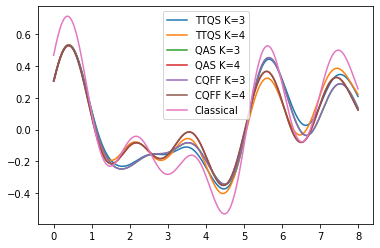

In [10]:
#What Ks we want to plot
whatK = [3,4]

#Here, we can either evaluate the O matrix classically, or with qiskit circuits

#Plotting results for TTQS
# plotp.QS_plotter_forobservable(num_qubits,finalresultsTTQS,times,whatK,'TTQS',observable,initial_state, evalmethod = "matrix_multiplication")
plotp.QS_plotter_forobservable(num_qubits,finalresultsTTQS,times,whatK,'TTQS',observable,initial_state, evalmethod = "qiskit_circuits", expectation_calculator = expectation_calculator)

#Plotting results for QAS
# plotp.QS_plotter_forobservable(num_qubits,finalresultsQAS,times,whatK,'QAS',observable,initial_state, evalmethod = "matrix_multiplication")
plotp.QS_plotter_forobservable(num_qubits,finalresultsQAS,times,whatK,'QAS',observable,initial_state, evalmethod = "qiskit_circuits", expectation_calculator = expectation_calculator)

#Plotting results for CQFF
# plotp.QS_plotter_forobservable(num_qubits,finalresultsCQFF,times,whatK,'CQFF',observable,initial_state, evalmethod = "matrix_multiplication")
plotp.QS_plotter_forobservable(num_qubits,finalresultsCQFF,times,whatK,'CQFF',observable,initial_state, evalmethod = "qiskit_circuits", expectation_calculator = expectation_calculator)

#Plotting classical result
observablematrix = observable.to_matrixform()
classicalresult = cS_instance.get_expectations_observables(observablematrix)
plotp.CS_plotter_forobservable(times,classicalresult)

#Show plot
plotp.show_plot()



Plotting fidelity for K = 3
C:\Users\Kian Hwee\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
Plotting fidelity for K = 4
C:\Users\Kian Hwee\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


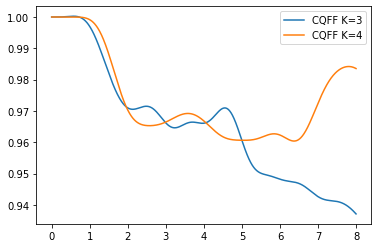

In [11]:
plotp.QS_plotter_for_fidelity(num_qubits, finalresultsCQFF, times, whatK, "CQFF", hamiltonian, initial_state)
# Show plot
plotp.show_plot()

### Saving calculated expectation values for future use

After all of the computation on the QM com, we can store the computed expectation values on the QM com like this:

Just uncomment the commented out lines in the cell below to try

In [12]:
import os 
from datetime import datetime
import pickle

#%% General helpful functions
if not os.path.exists('obj'):
    os.mkdir('obj')

def save_obj(obj, name):
    #name is a string
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    #name is a string
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

#Uncomment the chunk of code below to try the saving
# now = datetime.now() # datetime object containing current date and time
# dt_string = now.strftime("%d-%m-%Y %H_%M_%S")
# save_obj(expectation_calculator, "expectation_calculator_" + dt_string) #feel free to use a different filename.

We can also load the expectation_calculator by using the load_obj function. An example is shown below:

In [13]:
# expectation_calculator = load_obj(FILENAME_WITHOUT_pkl_EXTENSION)